In [1]:
import numpy as np
import matplotlib.pyplot as plt
from GW_class import *
import constants as c
from new_matched_filter import *

/opt/anaconda3/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
GW150914.dictionary['H1']['strain'].shape

(131072,)

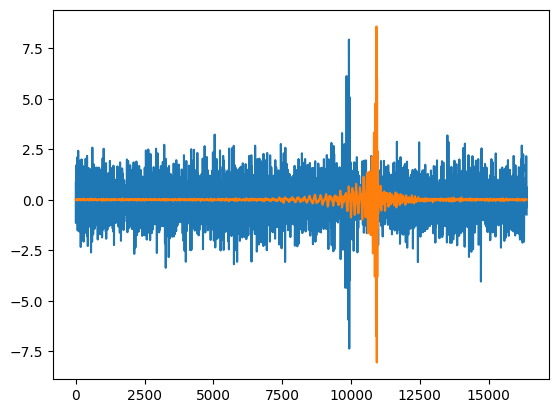

In [3]:
time = GW150914.dictionary['time']
time_center = GW150914.dictionary['time_center']
fs = GW150914.dictionary['fs']


# amount of data we want to calculate matched filter SNR over- up to 32s
data_time_window = time[len(time) - 1] - time[0] - (32 - 4)

time_filter_window = np.where((time <= time_center + data_time_window * .5) & 
                            (time >= time_center - data_time_window * .5))
time_filtered = time[time_filter_window]

# get data 
strain = GW150914.dictionary[det]['strain'][time_filter_window]
strain_whitenbp = GW150914.dictionary[det]['strain_whitenbp'][time_filter_window]

plt.plot(strain_whitenbp)

opt_template_TD, strain_whitenbp, time, SNRmax, temp_max, opt_phase = wrapped_matched_filter(GW150914.comp_params, GW150914, 'H1')

plt.plot(np.roll(opt_template_TD, 1000))

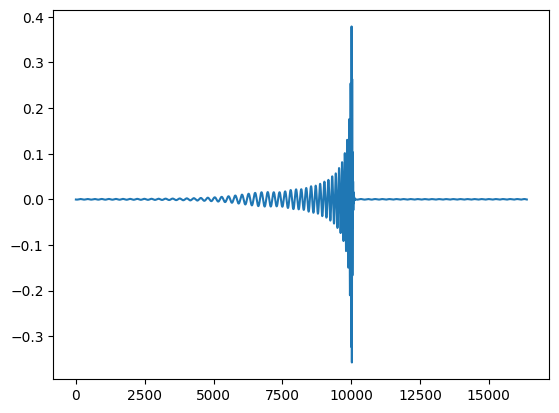

In [5]:
# get frequencies of our data
datafreq = c.freqs

template = get_template(GW150914.comp_params, GW150914.dictionary)

# get frequencies of our data
datafreq= c.freqs
# spacing between frequency bins
df = c.freqs[1] - c.freqs[0]

# get psd values from data dictionary
aLIGO_fs, aLIGO_sqrtS = np.loadtxt('aLIGO_sensitivity.txt').T
aLIGO_fs_full = np.concatenate((np.linspace(0., aLIGO_fs[0], 1000), aLIGO_fs))
aLIGO_sqrtS_full = np.concatenate((np.array([aLIGO_sqrtS[0]] * 1000), aLIGO_sqrtS))
sqrtS = interp1d(aLIGO_fs_full, aLIGO_sqrtS_full)(datafreq)

# calculate inner product for normalization
integrand = np.real(template * template.conjugate()) / sqrtS**2.
inner_product = 4 * np.sum(integrand) * df

# normalization 
p_normalization_factor = np.sqrt(inner_product)
#normalized template
p = template / p_normalization_factor
# GWsignals = GWSignals(signal_ref_params['GWsignal'][1], GWsignal, 2.4, 2.5)
# time shifts to search over for optimization
# time_shifts = waveform.times_full - waveform.times_full[0]

opt_template_FD = p * np.exp(-2. * np.pi * 1.j * c.freqs * 2.45)

# whiten template
opt_template_FD_whitened = opt_template_FD / sqrtS

# bandpass template
keep_ndxs = np.where(np.logical_and(c.freqs > 35., c.freqs < 350.))
mask = np.zeros_like(opt_template_FD)
mask[keep_ndxs] = 1.
opt_template_FD_whitened_bp = opt_template_FD_whitened * mask

# get whitened template in TD 
opt_template_TD_whitened = np.fft.irfft(opt_template_FD_whitened, waveform.times_full.shape[0]) * 4 * np.sqrt(fs)

opt_TD_template_unwhitened = np.fft.irfft(opt_template_FD, waveform.times_full.shape[0]) * 4 * np.sqrt(fs)

opt_TD_template_whitened_bp = np.fft.irfft(opt_template_FD_whitened_bp, waveform.times_full.shape[0]) * 4 * np.sqrt(fs)

plt.plot(opt_template_TD_whitened)
# plt.plot(GW150914.dictionary['H1']['strain_whitenbp'][time_filter_window])

In [6]:
simulated_dict = GW150914.dictionary.copy()

In [7]:
simulated_dict['H1']['strain'][time_filter_window] = opt_TD_template_unwhitened
simulated_dict['H1']['strain_whiten'][time_filter_window] = opt_template_TD_whitened
simulated_dict['H1']['strain_whitenbp'][time_filter_window] = opt_TD_template_whitened_bp
simulated_dict['L1']['strain'][time_filter_window] = opt_TD_template_unwhitened
simulated_dict['L1']['strain_whiten'][time_filter_window] = opt_template_TD_whitened
simulated_dict['L1']['strain_whitenbp'][time_filter_window] = opt_TD_template_whitened_bp

In [8]:
simulated_dict['H1']['data_FD'] = opt_template_FD
simulated_dict['L1']['data_FD'] = opt_template_FD

In [9]:
mask = np.zeros_like(simulated_dict['H1']['strain'], dtype=bool)
mask[time_filter_window] = True
simulated_dict['H1']['strain'][~mask] = 0
simulated_dict['H1']['strain_whiten'][~mask] = 0
simulated_dict['H1']['strain_whitenbp'][~mask] = 0
simulated_dict['L1']['strain'][~mask] = 0
simulated_dict['L1']['strain_whiten'][~mask] = 0
simulated_dict['L1']['strain_whitenbp'][~mask] = 0

In [10]:
simulated_dict['large_data_psds']['H1'] = interp1d(aLIGO_fs_full, aLIGO_sqrtS_full**2.)
simulated_dict['large_data_psds']['L1'] = interp1d(aLIGO_fs_full, aLIGO_sqrtS_full**2.)

In [11]:
with open('data/simulated_GW.pkl', 'wb') as f: pickle.dump(simulated_dict, f)

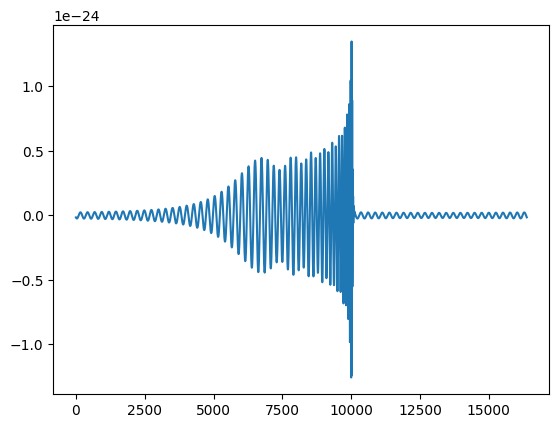

In [12]:
plt.plot(GW_simulated.dictionary['H1']['strain'][time_filter_window])